In [43]:
# imports
import requests
import json
import psycopg2
from psycopg2 import Error
import panel as pn
import plotly.express as px
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import os
from pathlib import Path
from dotenv import load_dotenv

import warnings
warnings.filterwarnings('ignore')

In [44]:
# Set up Panel Plotly extension
pn.extension('plotly')

In [45]:
# Import hvplot.pandas after pn.extension
# This avoids plotly initialization failure
import hvplot.pandas

In [46]:
# Define variables
column_names = ["symbol","exchange","industry","issueType", "Sector","country"]
final = pd.DataFrame()

In [47]:
# Read the Mapbox API key
load_dotenv('api_keys.env')
iex_cloud_api = os.getenv("IEX_CLOUD_API")
map_box_api = os.getenv("MAPBOX_TOKEN")
postgres_user = os.getenv("POSTGRES_USER")
postgres_pwd = os.getenv("POSTGRES_PWD")

px.set_mapbox_access_token(map_box_api)

In [48]:
def connect(params_dic):
    """ Connect to the PostgreSQL database server """
    conn = None
    try:
        # connect to the PostgreSQL server
        print('Connecting to the PostgreSQL database...')
        conn = psycopg2.connect(**params_dic)
    except (Exception, psycopg2.DatabaseError) as error:
        print(error)
        sys.exit(1) 
    print("Connection successful")
    return conn
 
def postgresql_to_dataframe(conn, select_query, columns):
    """
    Tranform a SELECT query into a pandas dataframe
    """
    cursor = conn.cursor()
    try:
        cursor.execute(select_query)
    except (Exception, psycopg2.DatabaseError) as error:
        print("Error: %s" % error)
        cursor.close()
        return 1
    
    # Naturally we get a list of tupples
    tupples = cursor.fetchall()
    cursor.close()
    
    # We just need to turn it into a pandas dataframe
    df = pd.DataFrame(tupples, columns=column_names)
    
    return df

In [49]:
# Connection parameters, yours will be different
param_dic = {
    "host"      : "localhost",
    "database"  : "project1_db",
    "user"      : postgres_user,
    "password"  : postgres_pwd
}

In [50]:
# create a connection to the database
conn = connect(param_dic)

Connecting to the PostgreSQL database...
Connection successful


In [51]:
# Import CSVs into dataframe
#df_tickers = ['TSLA', 'AAPL', 'MSFT', 'FB', 'C', 'T', 'VZ']
df_tickers = ['AMZN', 'BA', 'BABA', 'DAC', 'FLGT', 'PYPL']

In [52]:
# Base URL
iex_cloud_base_url = 'https://cloud.iexapis.com/stable'

In [57]:
# Iterate through positions
for ticker in df_tickers:
    # Check if ticker is in Database
    exists_query = f"SELECT EXISTS (select true from company where symbol='{ticker}');"
    exists = pd.read_sql(exists_query, conn)   
    if exists.iloc[0][0] == True:
        print(f'{ticker} In Database')
        company_query = f"SELECT symbol,exchange,industry,issueType,sector,country FROM company WHERE symbol='{ticker}';"
        df_temp = postgresql_to_dataframe(conn, company_query, column_names)
        final = pd.concat([final, df_temp])
    else:
        print(f'{ticker} Not in Database')
        # Query company info from api
        iex_cloud_company = (f'/stock/{ticker}/company?token={iex_cloud_api}')
        company_response = requests.get(iex_cloud_base_url + iex_cloud_company)
        data = company_response.json()
        #print(data)
        # Insert to database
        insert_query = "INSERT INTO company (symbol,companyName,exchange,industry,website,CEO," \
            "securityName,issueType,sector,primarySicCode,employees,address,address2,state,city,zip,country,phone)" \
            "VALUES('{0}','{1}','{2}','{3}','{4}','{5}','{6}','{7}','{8}','{9}','{10}','{11}','{12}','{13}','{14}'" \
            ",'{15}','{16}','{17}')".format(data.get('symbol'),
                                            data.get('companyName'),
                                            data.get('exchange'),
                                            data.get('industry'),
                                            data.get('website'),
                                            #data.get('description'),
                                            data.get('CEO'),
                                            data.get('securityName'),
                                            data.get('issueType'),
                                            data.get('sector'),
                                            data.get('primarySicCode'),
                                            data.get('employees'),
                                            #data.get('tags'),
                                            data.get('address'),
                                            data.get('address2'),
                                            data.get('state'),
                                            data.get('city'),
                                            data.get('zip'),
                                            data.get('country'),
                                            data.get('phone'))
        cursor = conn.cursor()                                                                
        cursor.execute(insert_query)
        # Add to dataframe
        #company_query = f"SELECT symbol,exchange,industry,issueType,sector,country FROM company WHERE symbol='{ticker}';"
        #df_temp = postgresql_to_dataframe(conn, company_query, column_names)
        #final = pd.concat([final, df_temp])


AMZN In Database
BA In Database
BABA In Database
DAC In Database
FLGT In Database
PYPL In Database


In [58]:
final

,symbol,exchange,industry,issueType,Sector,country
0,AMZN,NASDAQ/NGS (GLOBAL SELECT MARKET),Electronic Shopping and Mail-Order Houses,cs,Retail Trade,US
0,BA,"NEW YORK STOCK EXCHANGE, INC.",Small Arms Ammunition Manufacturing,cs,Manufacturing,US
0,BABA,"NEW YORK STOCK EXCHANGE, INC.",Software Publishers,ad,Information,China (Mainland)
0,DAC,"NEW YORK STOCK EXCHANGE, INC.",Deep Sea Freight Transportation,cs,Transportation and Warehousing,None
0,FLGT,NASDAQ/NMS (GLOBAL MARKET),Dental Laboratories,cs,Manufacturing,US
0,PYPL,NASDAQ/NGS (GLOBAL SELECT MARKET),"Data Processing, Hosting, and Related Services",cs,Information,US


In [59]:
count_sector = final['Sector'].value_counts()
count_industry = final['industry'].value_counts()

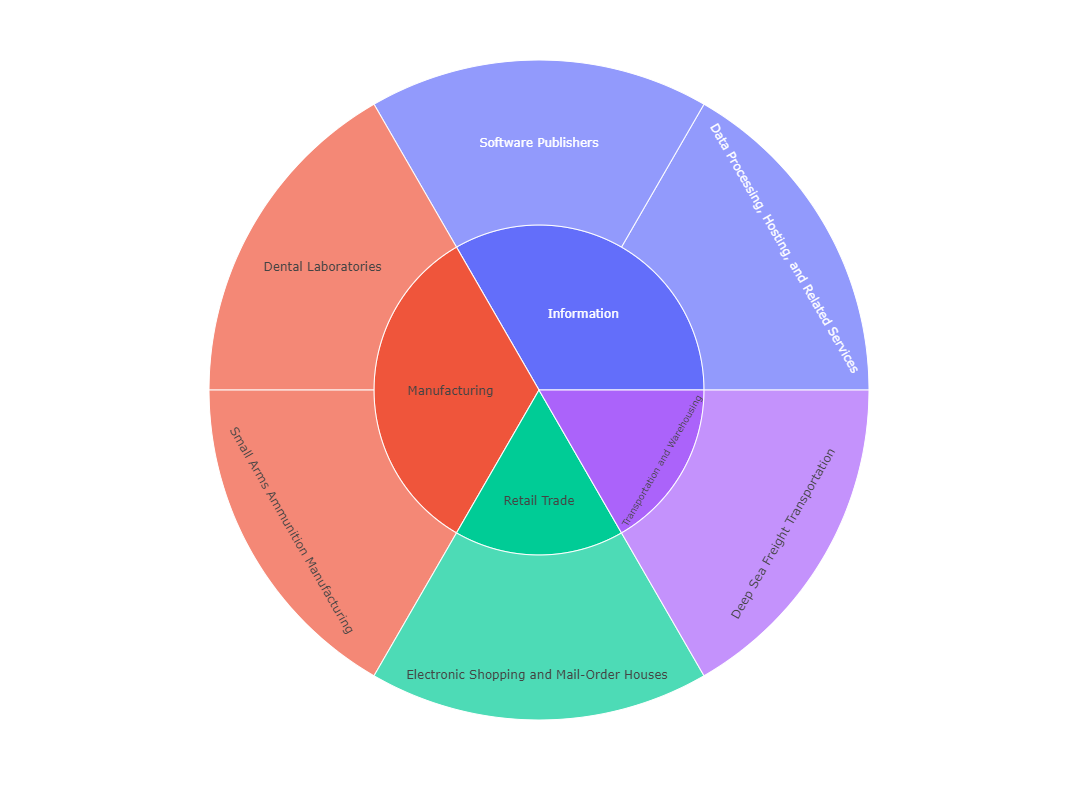

In [60]:
# Sunburst Plot
px.sunburst(
    final,
    path=['Sector', 'industry'],
    #values='total',
    #color='country',
    color_continuous_scale='blues',
    width=800,
    height=800
)